# Notebook version of Second Neural Network

This is a step-by-step implementation of the second neural network using MNIST dataset without neural network framework. 

## download basic functions used before

In [1]:
import sys, os
import os.path
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%shell
git clone https://github.com/HitoshiIyatomi/IIP1
#cp IIP1/common/gradient.py ./
#cp IIP1/common/functions.py ./
#cp IIP1/common/mnist.py ./
#cp IIP1/common/layers.py ./
#cp IIP1/common/util.py ./

Cloning into 'IIP1'...
remote: Enumerating objects: 148, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 148 (delta 43), reused 131 (delta 26), pack-reused 0
Receiving objects: 100% (148/148), 1.38 MiB | 31.38 MiB/s, done.
Resolving deltas: 100% (43/43), done.


### download MNIST dataset

This time, we use different MNIST data source.  
This dataset contain 50000 training and 10000 test dataset.

<class 'gzip.GzipFile'>
(50000, 784)
(10000, 784)
(50000,)
(10000,)


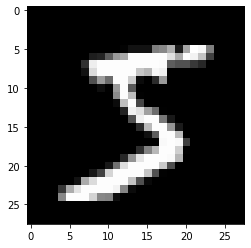

In [3]:
# this time, use different implementation 
from pathlib import Path
import requests
import gzip
import pickle

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"
PATH.mkdir(parents=True, exist_ok=True)
if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        print(type(f))
        ((x_train, t_train), (x_test, t_test), _) = pickle.load(f, encoding="latin-1")

plt.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)
print(x_test.shape)
print(t_train.shape)
print(t_test.shape)

### Definition of layers. 

Relu and Affine functions.  
(for reference purpose 
 - they are excerpt from common/layers.py)

In [4]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Affine:
    def __init__(self, W, b):
        self.W =W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # differential of weights (dW) and bias (db)
        self.dW = None
        self.db = None

    def forward(self, x):
        # consider Tensor (can be used GPU): 
        #  if input is tensor and has an extra dimension, eliminate it here. 
        # (e.g: torch.Size([1,100,100]) -> torch.Size([100,100]))
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # Return to the shape of the input data (Tensor support)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # output of softmax
        self.t = None # training signal

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # if training signal is in one-hot-vector
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

### Definition of two layer (traditional three layer) neural networks. (v2)  

input-hidden[RELU]-output[RELU]  

(two_layer_net2.py)

In [4]:
from collections import OrderedDict
from IIP1.common.gradient import numerical_gradient
from IIP1.common.layers import *

class TwoLayerNet2:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # weight initialization
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # definition of layer components.
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
            
        return x
        
   # x:input data, t:training data
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:input data, t:training data
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # setting
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads



### Functions for loading and managing MNIST dataset

(same as before: mnist.py)

### Training the network (v2)



In [6]:
### Training the network 
from IIP1.common.functions import *

network = TwoLayerNet2(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000   # set the number of training iteration
train_size = x_train.shape[0]
batch_size = 100    # set the batch size
learning_rate = 0.1 # set the learning rate at gradient descent

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # gradient
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # update weights
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # display the progress of the training
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("epoch= {:5d} train_acc = {:.4f}, test_acc = {:.4f}".format(int(i/iter_per_epoch),train_acc, test_acc))

epoch=     0 train_acc = 0.1212, test_acc = 0.1221
epoch=     1 train_acc = 0.8952, test_acc = 0.9061
epoch=     2 train_acc = 0.9150, test_acc = 0.9221
epoch=     3 train_acc = 0.9295, test_acc = 0.9329
epoch=     4 train_acc = 0.9387, test_acc = 0.9427
epoch=     5 train_acc = 0.9473, test_acc = 0.9490
epoch=     6 train_acc = 0.9511, test_acc = 0.9530
epoch=     7 train_acc = 0.9583, test_acc = 0.9580
epoch=     8 train_acc = 0.9604, test_acc = 0.9600
epoch=     9 train_acc = 0.9626, test_acc = 0.9606
epoch=    10 train_acc = 0.9663, test_acc = 0.9632
epoch=    11 train_acc = 0.9687, test_acc = 0.9651
epoch=    12 train_acc = 0.9711, test_acc = 0.9658
epoch=    13 train_acc = 0.9718, test_acc = 0.9674
epoch=    14 train_acc = 0.9748, test_acc = 0.9685
epoch=    15 train_acc = 0.9759, test_acc = 0.9695
epoch=    16 train_acc = 0.9771, test_acc = 0.9706
epoch=    17 train_acc = 0.9781, test_acc = 0.9714
epoch=    18 train_acc = 0.9781, test_acc = 0.9700
epoch=    19 train_acc = 0.9801

### Draw a training curve (same)

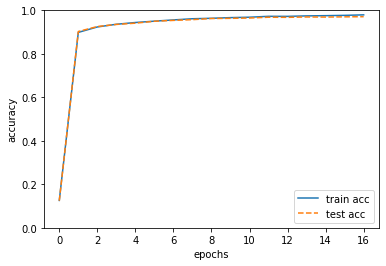

In [ ]:
# draw graph
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()